In [1]:
#!pip install transformers
#!pip install datasets
#!pip install fastai
#!pip install ohmeow-blurr

# Skript3: Model Finetuning für Text-Klassifizierung mit germaneval2019 Task3 -Subtask2 mit Fast-AI

Dieses Notebook beschreibt das Training eines Text-Klassifizierungsmodells für den Datensatz GermEval 2019 Task2 -Subtask3.
Es wird ein BERT - Modell mit der Fast-AI und der Blurr Bibliothek trainiert. Das Training erfolgt nach dem gleichen Split wie es der Shared Task 2019 vorgab.

In [2]:
# Importieren der Hugging Face Datesets Bibliothek
import datasets
from fastai.text.all import *
from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Parameter für die Scriptsteuerung:
# die Task für die das Modell trainiert werden soll
task = "task3"
# das zu verwendende pretrained Transformer Modell
model_checkpoint = "deepset/gbert-base"
# die Trainingsbatchsize
batch_size = 4

In [4]:
num_labels = 2
y_col = "task3_label"

## Herunterladen und Bereitstellen der Transformers Komponenten.
Dafür wird lediglich der gewünschte model_checkpoint an die Methode `BLURR_MODEL_HELPER.get_hf_objects` übergeben. Diese beschafft das entsprechende Model und die zugehörigen Daten wie den Tokenizer für die gewählte Task:

In [5]:
hf_task = HF_TASKS_AUTO.SequenceClassification
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(model_checkpoint, task=hf_task,config_kwargs={'num_labels': num_labels})

## Preprocessing des Datasets

In [6]:
import pandas as pd

Zunächst werden  alle Trainingsdaten aus dem GermEval2019 Dataset zu einem Pandas Dataframe zusammengefügt:

In [7]:
data_all=pd.read_csv("../datasets/germeval2019/train_valid/germeval2019.training_subtask3.txt",delimiter="\t", header=None,quoting=3)
data_all.columns = ["text","task1_label","task2_label","task3_label"]
data_all.head()

,text,task1_label,task2_label,task3_label
0,@spdde kein verläßlicher Verhandlungspartner. Nachkarteln nach den Sondierzngsgesprächen - schickt diese Stümper #SPD in die Versenkung.,OFFENSE,INSULT,EXPLICIT
1,@milenahanm 33 bis 45 habe ich noch gar nicht gelebt und es geht mir am Arsch vorbei was in dieser Zeit geschehen ist. Ich lebe im heute und jetzt und nicht in der Vergangenheit.,OFFENSE,PROFANITY,EXPLICIT
2,@tagesschau Euere AfD Hetze wirkt. Da könnt ihr stolz sein bei #ARD-Fernsehen,OFFENSE,ABUSE,EXPLICIT
3,"Deutsche Medien, Halbwahrheiten und einseitige Betrachtung, wie bei allen vom Staat finanzierten ""billigen"" Propagandainstitutionen 😜",OFFENSE,ABUSE,EXPLICIT
4,@Ralf_Stegner Oman Ralle..dich mag ja immer noch keiner. Du willst das die Hetze gegen dich aufhört? |LBR| Geh in Rente und verzichte auf die 1/2deiner Pension,OFFENSE,INSULT,EXPLICIT


Verarbeiten des Testdatensatzes in einen Dataframe:

In [8]:
data_test = pd.read_csv("../datasets/germeval2019/test/germeval2019GoldLabelsSubtask3.txt",delimiter="\t", header=None, quoting=3)
data_test.columns = ["text","task1_label","task2_label","task3_label"]
# Fügt eine Spalte is_valid ein die eine Zeile makiert als Teil des Validationsets
data_test['is_valid']=True
dummy_row ={'text':'dummy','task1_label':'OTHER','task2_label':"OTHER","task3_label":"EXPLICIT",'is_valid':False}
# Einfügen der Dummyzeile, sodass im Anschluss im DataBlock der ColSplitter verwendet werden kann und das Testset komplett ist
data_test = data_test.append(dummy_row,ignore_index=True)
data_test.tail()

,text,task1_label,task2_label,task3_label,is_valid
926,@rspctfl @ThomasMichael71 @Innenwelttramp @ergroovt @houelle_beck @ksemann2 @DrKassandraPari Du bist als Muslima aber kein Ausdruck verschiedener Religionen. Du bist eine religiöse Fanatikerin.,OFFENSE,ABUSE,EXPLICIT,True
927,"Merkel zerstört den bürgerlich-konservativen Kern dieses Landes, auf den jede Zivilisation angewiesen ist.",OFFENSE,ABUSE,EXPLICIT,True
928,Feminismus ist der Islamismus der Weiblichkeit.,OFFENSE,ABUSE,EXPLICIT,True
929,@ThomasMichael71 @mountainman1977 @houelle_beck Die israelische Verwaltung der Westbank ist nichts anderes als die polnische Verwaltung der deutschen Ostgebiete zwischen 1945 und 1990. Außer dass Israel den dort lebenden Arabern Autonomierechte gewährt.,OFFENSE,ABUSE,IMPLICIT,True
930,dummy,OTHER,OTHER,EXPLICIT,False


## Erstellen der DataLoader via DataBlock API

Um die Trainingsdaten in das Modell zu füttern, wird in Fast-AI ein DataLoader benötigt. Dieser kann mit der DataBlock API erstellt werden. Hierfür übergibt man dem Konstruktur die entsprechenden Blöcke und Informationen darüber, wie die x und y Variable aus den Datensätzen zu ermitteln sind.\
Der `HF_TextBlock` wird verwendet, weil die x-Variable roher Text ist. Der Block kümmert sich um die Anreicherung und Tokenisierung der Eingabedaten des Modells. Dafür wird automatisch der zugehörige Tokenizer der Transformerarchitektur verwendet.\
Der zweite Block bestimmt die Natur der y-Variable. Da es sich hier um ein Klassifizierungsproblem handelt, wird der `CategoryBlock` verwendet. Dieser wandelt die Inhalte der Labelspalte automatisch in entsprechende Kategorieencodings um.\
Durch die Parameter `get_x` und `get_y` kann dem `DataBlock` mitgeteilt werden, wie er die x- und y-Variable beschaffen soll. In diesem Fall wird dies mit einem `ColReader` durchgeführt, welcher die entsprechenden Werte aus der Spalte `text` und der Labelspalte extrahiert.\
Der `splitter` Parameter bestimmt, wie der Datensatz aufgeteilt werden soll. Der gewählte Splitter ist der `RandomSplitter`. Dieser ordent die Daten zufällig dem Trainings und dem Validierungsset zu. Die gewählte Aufteilung ist 80 % Trainingsset und 20 % Validierungsset.


In [9]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock())
dblock = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader(y_col), splitter=RandomSplitter(valid_pct=0.2, seed=42))

Mithilfe der `summary` Methode kann man einen Problelauf des DataBlock starten. Die Ausgabe gibt Auskünfte darüber, was während der Verabeitung der Daten passiert und ob es zu Fehlern kommt. 

In [10]:
dblock.summary(data_all)

Setting-up type transforms pipelines
0                                               @spdde kein verläßlicher Verhandlungspartner. Nachkarteln nach den Sondierzngsgesprächen - schickt diese Stümper #SPD in die Versenkung.   
1     @milenahanm 33 bis 45 habe ich noch gar nicht gelebt und es geht mir am Arsch vorbei was in dieser Zeit geschehen ist. Ich lebe im heute und jetzt und nicht in der Vergangenheit.   
2                                                                                                          @tagesschau Euere AfD Hetze wirkt. Da könnt ihr stolz sein bei #ARD-Fernsehen   
3                                                  Deutsche Medien, Halbwahrheiten und einseitige Betrachtung, wie bei allen vom Staat finanzierten "billigen" Propagandainstitutionen 😜   
4                        @Ralf_Stegner Oman Ralle..dich mag ja immer noch keiner. Du willst das die Hetze gegen dich aufhört? |LBR| Geh in Rente und verzichte auf die 1/2deiner Pension   
...                    

Im Anschluss kann der `DataLoader` für die Trainingsdaten erzeugt werden. Die verwendete Batch Size liegt bei 4 aufgrund der begrenzten Speicherkapazitäten der verwendeten GPU.

In [11]:
dls =  dblock.dataloaders(source=data_all,bs=batch_size,shuffle=True)

Wie mit jedem `DataLoader` in Fast-AI kann auch hier ein Beispiel Batch visualisiert werden. Dies wird mit der Methode `show_batch` gestartet.

In [12]:
dls.show_batch(dataloaders=dls)

,text,category
0,"@ Steffmann45 @ troll _ putin @ petpanther0 @ mastermikeg @ machtjanix23 @ Norbinator2403 @ ennof _ @ AthinaMala @ NancyPeggyMandy @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ NoHerrman @ willjrosenblatt @ feldenfrizz @ nasanasal @ _ macmike @ ellibisathide @ MD _ Franz Bursche, Du hast keine Ahnung und kannst offensichtlich auch nicht Tatorte analysieren. Follower hast Du auch kaum, zieh ab, PS Bilderberger waren in D bis zum Treffen in Dresden auch Verschwörungstheorie - Gott gibts doofe Leute in D!",EXPLICIT
1,"@ Lotstep1 @ SteinbachErika Nix Sezession, der Ruhrpott ist mir, woll! Und wer dat nich will dem komm ich dabei! Bei mir weht die DEUTSCHE FAHNE, nicht wie Merkel die unsere Fahne in den Dreck schmeißt und draufspuckt! Das Video kennt jeder, das ist ihre Einstellung zu unserem Land! Blutmerkel!",EXPLICIT
2,Mal schauen wieviel # Frauen dieses Jahr von illegalen Einwanderern # vergewaltigt oder # belästigt werden. | LBR | Ich hoffe aufrichtig sollte es dieses Jahr # Silvester wieder eskalieren dass sich die Europäer endlich erheben und es zum # Aufstand kommt der in die Geschichte eingehen wird.,EXPLICIT
3,"Schon merkwürdig wie brav die # Moslems sich in # Russland verhalten. Dort stellen Moslems keine Forderungen. Dort greift man auch keine Polizisten an, # vergewaltigt # Frauen und # Mädchen. Auch demonstrieren dort kein # Moslems oder # Schwarzafrikaner. | LBR | Woran das wohl liegen mag?",IMPLICIT


Um das Modell im Anschluss des Trainings mit den ungesehenen Testdaten prüfen zu können, müssen diese ebenfalls durch einen `DataLoader` zur Verfügung gestellt werden. Dafür wird ein weiterer `DataBlock` erzeugt, der als Blaupause für den `DataLoader` dienen wird. Der folgende `DataBlock` unterscheidet sich nur im gewählten `splitter` vom vorherigen. Der `ColSplitter` ermöglicht es, die Datensätze eines DataFrames automatisch nach dem Inhalt der Spalte `is_valid` aufzuteilen. Dabei wird jeder Datensatz dem Validierungsset zugeordnet, der den Wert `True` in dieser Spalte enthält.

In [13]:
blocks_test = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock())
dblock_test = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader(y_col), splitter=ColSplitter())

In [14]:
dls_test = dblock_test.dataloaders(source=data_test,bs=batch_size,shuffle=True)

Ausgabe eines Beispielbatches aus dem Testset:

In [15]:
dls_test.valid.show_batch(dataloaders=dls_test)

,text,category
0,"@ SJW _ MadBunny @ troll _ putin @ machtjanix23 @ Steffmann45 @ petpanther0 @ mastermikeg @ Norbinator2403 @ ennof _ @ AthinaMala @ NancyPeggyMandy @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ NoHerrman @ willjrosenblatt @ feldenfrizz @ nasanasal @ _ macmike @ ellibisathide @ MD _ Franz @ sjw Seit diese Pfosten sich gestern eingeschaltet hatten, ging es mit dem Niveau bergab - wir sprachen gestern über FEMA - das ist lang her - und die Nerven liegen blank, der Klugscheißer wegen.",EXPLICIT
1,"@ mastermikeg @ machtjanix23 @ AthinaMala @ _ macmike @ Norbinator2403 @ ennof _ @ troll _ putin @ NancyPeggyMandy @ petpanther0 @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ NoHerrman @ willjrosenblatt @ feldenfrizz @ nasanasal @ ellibisathide @ MD _ Franz Der Typ hat sich mit etlichen hier angelegt, hat inhaltlich nichts zu bieten - nur Klugscheißern. Eigenes hat er auch nicht zu bieten - dafür reicht sein Intellekt nicht.",EXPLICIT
2,@ troll _ putin @ SJW _ MadBunny @ machtjanix23 @ Steffmann45 @ petpanther0 @ mastermikeg @ Norbinator2403 @ ennof _ @ AthinaMala @ NancyPeggyMandy @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ NoHerrman @ willjrosenblatt @ feldenfrizz @ nasanasal @ _ macmike @ ellibisathide @ MD _ Franz @ sjw Vielleicht hat sie genauso wie ich die Nase voll von Oberlehrern mit dem von Barnett angestrebten IQ 90.,EXPLICIT
3,"@ MotziKlaus @ J _ B _ oo7 @ MiriamOzen @ VonSchwer @ NancyPeggyMandy @ Maggielein _ @ ellibisathide @ Ich _ bin _ ich78 @ ichbinkoelnerin @ lawyerberlin @ NorgePrivacy @ MD _ Franz @ SM100d @ SteinbachErika @ IQ _ Stimulator @ PetrBystronAfD @ FabriziaFalcone @ emrich _ 5933 @ drbrandner @ ibikus31 @ KrahMax Ich frage mich täglich, was man den Leuten ins Essen getan hat, dass sie so dumm und naiv geworden sind....",EXPLICIT


#### Exploration der verarbeiteten Daten

Wie sehen nun die Daten aus, die das Modell füttern? Das kann herausgefunden werden, indem man sich vom `DataLoader` einen Batch geben lässt:

In [16]:
b = dls.one_batch()
b

({'input_ids': tensor([[  102, 17329,   735,   273,   892,  3132, 17329,  7550,   137,  2032,
             295,  9753, 17329, 10602,  5239,   548,   452, 30911, 17329,  6138,
             409,  6120,   533, 30894, 17329,  2122, 11348,  2345,  2485, 17329,
            2457,  3257,  1815,  2217, 12507, 17329, 16469,  2113,  2032, 17329,
           13872,  1422, 24289, 30887, 17329, 27560, 17225,  6832, 30933,  7597,
            5338, 17329, 13267,   559,  5301, 17329, 29099,   997,  3969, 17329,
            3574,  8733,  1148, 17329,  6495,  2404,  7377,   269, 17329,  8824,
             346,  2032, 15870, 25753, 30881, 17329,  5120, 23062,  1306, 17329,
             978, 28980,  5821,  5344, 17329,  5379,  4300,   106,  2259, 19207,
           17329,  5587, 10138, 12596, 30891, 17329,  2032,  6138,  8220,  5718,
           17329, 25145,  1218,  8120,  1198,  1579, 17329, 25704,  2032,  3332,
            2054,  1032,   818,   840,  1838,   855, 10369,   136,  4803,  9965,
             31

Man sieht den klassischen Aufbau des Inputs. Dieser besteht aus den `input_ids`, den `token_type_ids`, der `attention_mask` und Tensor Kategorien für das y-Label. Auch hier ist die Batchsize von 4 erkennbar, denn es liegen für jedes Attribut von `b` 4 Listen oder Werte vor. Jede einen zusammengehörigen Datensatz.

In [17]:
len(b),len(b[0]['input_ids']), b[0]['input_ids'].shape, len(b[1]) 

(2, 4, torch.Size([4, 170]), 4)

Mithilfe der `input_ids` und dem `hf_tokenizer` können die Tensoren ebenfalls wieder in ihre Textform decodiert werden:
- Es ist erkennbar, dass die BERT typischen Special Tokens nun in der Sequenz enthalten sind
- Ebenfalls wurden bei Bedarf Padding Tokens eingefügt

In [18]:
hf_tokenizer.decode(b[0]['input_ids'][1])

'[CLS] @ SJW _ MadBunny @ machtjanix23 @ Steffmann45 @ troll _ putin @ petpanther0 @ mastermikeg @ Norbinator2403 @ ennof _ @ AthinaMala @ NancyPeggyMandy @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ NoHerrman @ willjrosenblatt @ feldenfrizz @ nasanasal @ _ macmike @ ellibisathide @ MD _ Franz Tja, entweder hat @ machtjanix früher gelogen und sich verstellt, oder er war nie anders - mich langweilt der Scheiß enorm. Ich guck gleich zu meinen Nicht - Deutschen Followern - das ist interessant und aufbauend. [SEP]'

## Finetuning des Modells

Es kann nun der Fast-AI `Learner` erzeugt werden. Für die Kompatibilität mit der Transformer Architektur muss das Modell mit dem `HF_BaseModelWrapper` gewrappt werden. Dem `Learner` wird der Trainings-DataLoader, die Modellarchitektur, die Optimierungsfunktion, die Lossfunktion, die zu berechnenden Metriken sowie für die Kompatibilität noch Callbacks und Modellsplitter aus der Blurr Bibliothek.

In [19]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy,Recall(average='macro'),Precision(average="macro"),F1Score(average="macro")],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

In [20]:
learn.create_opt()

In [21]:
learn.freeze()

Mit der Methode `learn.blurr_summary()` kann man sich eine Zusammenfassung zum Modell anschauen. Der Bericht enthält Informationen zum Aufbau des Modells sowie über die Anzahl der Parameter und ob diese trainierbar sind. Da das Modell gefroren wurde kann nur der finale Layer sowie die LayerNorm der darunter liegenden Layer trainiert werden.

In [22]:
learn.blurr_summary()

HF_BaseModelWrapper (Input shape: 4 x 165)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 165 x 768       
Embedding                                 23886336   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
      

Der Report zeigt an, dass im eingefrorenen Zustand nur 39938 von 109929218 Parametern trainiert werden.

#### Finden einer guten Learning Rate

Durch die Integration mit Fast-AI kann nun auch der integrierte Learning Rate Finder genutzt werden:

0.0007585775572806596

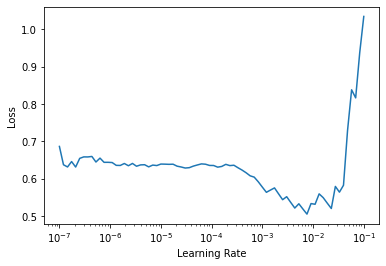

In [23]:
lr_min, _ = learn.lr_find(suggestions=True)
lr_min

Anschließend kann das Training über die `fit_one_cycle` Methode gestartet werden. \
Hierfür wird zunächst nur der oberste Layer des Modells trainiert, da die anderen eingefroren wurden.

In [24]:
learn.fit_one_cycle(1,lr_max=lr_min)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.357030,0.339792,0.869565,0.509615,0.934615,0.483889,00:26


Nach nur einer Epoch erreicht das Modell bereits eine Accuracy von 86,96 %.

Über das `Learner` Objekt kann man sich anschließend ein paar Beispiel Vorhersagen anzeigen lassen:

In [25]:
learn.show_results(learner=learn)

,text,category,target
0,"@ Steffmann45 @ troll _ putin @ petpanther0 @ mastermikeg @ machtjanix23 @ Norbinator2403 @ ennof _ @ AthinaMala @ NancyPeggyMandy @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ NoHerrman @ willjrosenblatt @ feldenfrizz @ nasanasal @ _ macmike @ ellibisathide @ MD _ Franz Erklärung kannst Du also auch keine geben, die Fotos entstammen der Akte, Ps sie wurden auch im Prozess gezeigt, der ist öffentlich. Na los, erklär mal die saubere Wand, ansonsten halt besser Deinen Oberlehrerschnabel.",EXPLICIT,EXPLICIT
1,"@ AthinaMala @ machtjanix23 @ SpadeCarrier @ _ macmike @ magna _ est @ petpanther0 @ NoHerrman @ teite99 @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ willjrosenblatt @ feldenfrizz @ nasanasal @ ellibisathide @ MD _ Franz Die Antwort ist wieder passend, die sie Dir gegeben hat - nun ist auch der Beleg Hirnriss nach Ao s Meinung - mal eine Frage : Wieso verschwendet ihr eure Zeit mit dieser Unterbelichteten?",EXPLICIT,EXPLICIT
2,"@ ibikus31 @ BlondJedi @ Beatrix _ vStorch @ CDU @ CSU @ spdbt @ Die _ Gruenen @ RegSprecher @ GottfriedCurio @ fdp @ Linksfraktion Weil der Rest, also der überflüßige MÜLL, im BT, so PERVERS, PÄDOPHIL, RASSISTISCH, GIERIG, MACHTGEIL, KRIMINELL, IDEOLOGISIERT, POPULISTISCH, HETZERISCH, ANTIDEUTSCH, WURZELLOS und häßlich wie Claudia Roth oder Stegner sind. Kohn Bendit ist auch so einer, der seine Rechnung bekommen sollte",EXPLICIT,EXPLICIT
3,"@ mastermikeg @ machtjanix23 @ troll _ putin @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ AthinaMala @ charlie _ silve @ NoHerrman @ willjrosenblatt @ petpanther0 @ feldenfrizz @ nasanasal @ info2099 @ _ macmike @ ellibisathide @ MD _ Franz Könntet ihr mich bitte aus dem Thread rausnehmen, das Klugscheißern von Ao und dessen oberlehrerhaften Bevormundungen gehen einem langsam auf den Sack. Danke",EXPLICIT,EXPLICIT


#### Ausprobieren der Vorhersage eigener Beispiele
Sobald man ein trainiertes Modell hat, kann man dieses via `blurr_predict` Vorhersagen treffen lassen. Hierfür muss man wie bei der Hugging Face Transformer Pipeline nur einen String übergeben und erhält als Ergebnis die Vorhersage des Modells zurück.

In [26]:
learn.blurr_predict('Du bist eine dumme Sau!')

[(('EXPLICIT',), (#1) [tensor(0)], (#1) [tensor([0.7509, 0.2491])])]

In [32]:
learn.blurr_predict("Das klingt so als wäre da jemand als Baby vom Wickeltisch gefallen @UriGer")

[(('EXPLICIT',), (#1) [tensor(0)], (#1) [tensor([0.8056, 0.1944])])]

#### Trainieren der tieferen Layer
Um auch die tieferen Layer des Modells trainieren zu können, muss es zunächst unfreezed werden:

In [33]:
learn.unfreeze()

Anschließend kann man wieder den Learning Rate Finder nutzen, um den LR Parameter einzustellen:

2.2908675418875645e-07

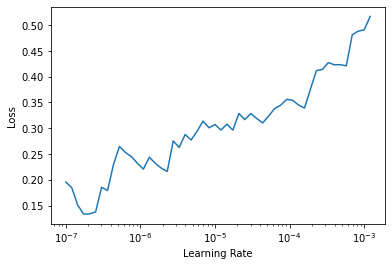

In [35]:
lr_min, _ = learn.lr_find()
lr_min

In [36]:
learn.fit_one_cycle(4,lr_max=slice(lr_min,1e-4))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.349728,0.312494,0.874680,0.561408,0.758971,0.577036,00:41
1,0.305101,0.298523,0.859335,0.601401,0.670271,0.621264,00:42
2,0.235324,0.301447,0.864450,0.604351,0.687169,0.626861,00:42
3,0.220340,0.302837,0.864450,0.604351,0.687169,0.626861,00:42


Der eingebaute Recorder ermöglicht es, den Verlauf der Loss über das Training zu plotten.

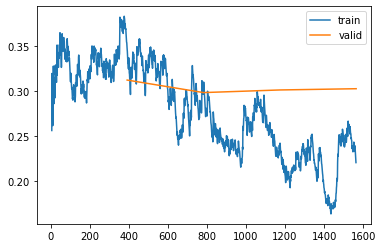

In [37]:
learn.recorder.plot_loss()

Der Graph deutet an, dass sich das Modell von einem Underfitting Zustand nach der zweiten Epoch in einen leichten Overfitting Zustand wechselt. Das Overfitting ist jedoch nicht signifikant.

#### Evaluation des Modells mit dem Testset
Das Modell kann anschließend über die `validate` Methode evaluiert werden. Dafür wird der DataLoader des Testdatensatz übergeben. Als Ausgabe erhält man die berechneten Metriken zurück:

In [38]:
learn.validate(dl=dls_test.valid)

(#5) [0.32278046011924744,0.874193549156189,0.641012900322508,0.7601304024489373,0.6736930177323148]

#### Speichern des Models

In [39]:
learn.export(fname=f'./deepset_finetuned/offensive_language_deepset_{task}_standard_finetune_gem_germeval2019_split_makrof1_fastai.pkl')

#### Trainieren eines Modells mit mehr Schritten beim Gradual Unfreezing
In diesem Abschnitt soll getestet werden, ob mit weiteren Unfreezing Schritten eine bessere Modellperformance erreicht werden kann.

In [20]:
# Erzeugen einer neuen Modellinstanz
_, _, _, hf_model2 = BLURR_MODEL_HELPER.get_hf_objects(model_checkpoint, task=hf_task,config_kwargs={'num_labels': num_labels})

model2 = HF_BaseModelWrapper(hf_model2)

learn2 = Learner(dls, 
                model2,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy,Recall(average='macro'),Precision(average="macro"),F1Score(average="macro")],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()
learn2.create_opt()
learn2.freeze()

Nachdem der zweite Learner erzeugt wurde und alle Layer eingefroren wurden, kann auch hier die LR gesucht werden.

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.02754228748381138)

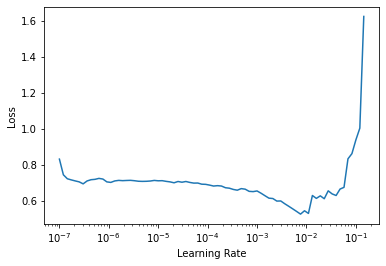

In [22]:
learn2.lr_find()

Der LR-Finder schlägt eine LR von 7E-4 vor. Anhand des Plots kann jeodch erkannt werden, dass eine leicht agressivere LR von 1E-3 genutzt werden kann. Der finale Layer des Modells wird anschließend mit dieser LR trainiert.

In [23]:
learn2.fit_one_cycle(1,1e-3)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.304122,0.343931,0.867008,0.500000,0.433504,0.464384,00:23


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dieses Modell erreicht bereits nach einer Epoch eine Accuracy von 86,70%.

Anschließend kann das Modell mit der Methode freeze_to() stufenweise unfreezed werden, um immer mehr Parametergruppen zusammen zutrainieren (Gradual Unfreezing):

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

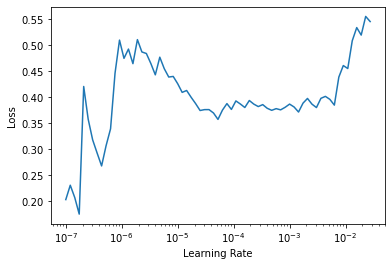

In [27]:
learn2.freeze_to(-2)
learn2.lr_find()

Da der Learning Rate Finder bei Transformer Modellen eine Tendenz zu sehr kleinen LRs hat, wird eher der Graph zu Ermittlung einer geeigneten LR von mir verwendet. Im zweiten Trainingsschritt werden die entfrorenen Layer mit einer etwas agressiveren LR von 1E-5 (finaler Layer) für eine Epoch trainiert:

Die Verwendung der `slice`-Syntax erlaubt es den ersten Wert für die ersten Layer des Modells zu verwenden und den zweiten für den finalen Layer. Die Layer dazwischen erhalten gleichverteilte LR zwischen den beiden Parameterwerten. \
Das der erste Wert durch 2.6**4 geteilt wird, ist eine Empfehlung aus dem Buch "Deep Learning for Coders with fastai and PyTorch" S.349

In [28]:
learn2.fit_one_cycle(1,slice(1e-5/2.6**4,1e-5))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.319826,0.336560,0.864450,0.506666,0.600945,0.481731,00:24


Anschließend wird erneut ein weiterer Layer des Modelles entfroren und die LR bestimmt:

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=6.309573450380412e-07)

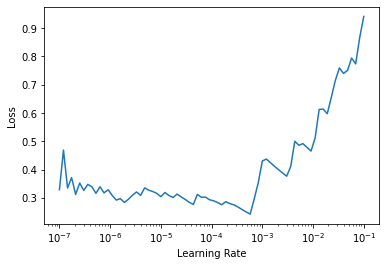

In [32]:
learn2.freeze_to(-3)
learn2.lr_find()

In [33]:
learn2.fit_one_cycle(1,slice(5e-5/2.6**4,5e-5))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.271165,0.318581,0.869565,0.542177,0.716259,0.546600,00:38


Da es keine weiteren Parametergruppen mehr gibt kann nun das gesamte Modell unfreezed werden. Anschließend wird wieder die LR bestimmt und das Modell für weitere Epochs 4 trainiert.

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=1.5848931980144698e-06)

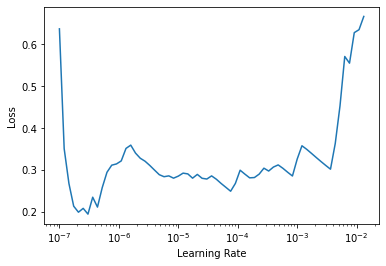

In [35]:
learn2.unfreeze()
learn2.lr_find()

Der LR Finder schlägt eine LR von 7E-6 vor. Anhand des Graph erkennt man, dass an dieser Stelle sich die Lossfunktion nicht verbessert. Daher wird eine leicht defensivere LR von 2E-6 genutzt. An dieser Stelle befindet sich die Lossfunktioskurve in einer Abwärtsbewegung.

In [36]:
learn2.fit_one_cycle(4,slice(2e-6/2.6**4,2e-6))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.300277,0.316530,0.859335,0.544418,0.638830,0.551091,00:38
1,0.294805,0.314557,0.859335,0.560699,0.651387,0.573998,00:38
2,0.265445,0.313985,0.859335,0.560699,0.651387,0.573998,00:38
3,0.230222,0.313854,0.859335,0.560699,0.651387,0.573998,00:39


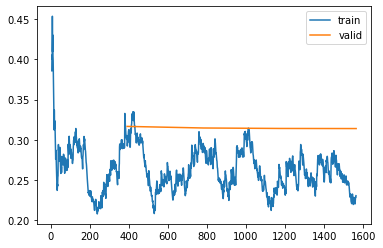

In [37]:
learn2.recorder.plot_loss()

Der Verlauf der Losskurven deutet auf kein Over- oder Underfitting des Modells hin. 

In [38]:
learn2.validate(dl=dls_test.valid)

(#5) [0.3107823133468628,0.8698924779891968,0.5764362859071477,0.792547274749722,0.5976401179941002]

Da noch kein Overfitting vorliegt kann das Modell noch weiter trainiert werden:

In [39]:
learn2.fit_one_cycle(4,slice(2e-5/2.6**4,2e-5))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.223953,0.313637,0.864450,0.612491,0.688893,0.635036,00:38
1,0.250843,0.313835,0.856777,0.624348,0.671518,0.641472,00:39
2,0.237371,0.318241,0.856777,0.648769,0.678913,0.661430,00:38
3,0.175518,0.319683,0.856777,0.632488,0.674109,0.648426,00:38


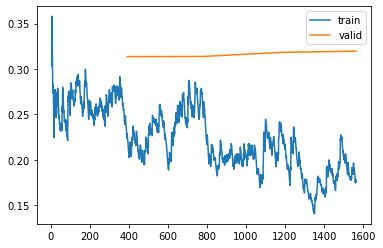

In [40]:
learn2.recorder.plot_loss()

Der Validationlosswert deutet nun auf ein beginnendes Overfitting des Modells hin. Daher wird nachfolgend kein weiteres Feintuning des Modells betrieben. Stattdessen wird eneut die Validierung gegen das Testset durchgeführt:

In [41]:
learn2.validate(dl=dls_test.valid)

(#5) [0.31826063990592957,0.874193549156189,0.6689417235430886,0.750887573964497,0.6972277178132278]

Als Ergebnis kann für diesen Datensatz festgestellt werden, dass die erweiterte Anwendung der Best Practice Methoden Gradual Unfreezing und Discriminative Fintuning eine leichte Erhöhung des F1-Scores erreicht werden konnte.

#### Anwendung des gespeicherten Modells
Um das gespeicherte Modell anzuwenden, muss dieses zunächst geladen werden: 

In [40]:
saved_model = load_learner(fname=f'./deepset_finetuned/offensive_language_deepset_{task}_standard_finetune_gem_germeval2019_split_makrof1_fastai.pkl')

Anschließend kann die `blurr_predict` Methode genutzt werden, um Vorhersagen zu generieren:

In [41]:
saved_model.blurr_predict("Unglaublich wie beschissen du heute gespielt hast @ThomasMüller")

[(('EXPLICIT',), (#1) [tensor(0)], (#1) [tensor([0.9310, 0.0690])])]

In [44]:
saved_model.blurr_predict('Das klingt so als wäre da jemand als Baby vom Wickeltisch gefallen @UriGE')

[(('EXPLICIT',), (#1) [tensor(0)], (#1) [tensor([0.8227, 0.1773])])]